,location,time,day,hour,sep_hour,location_name
0,0,00:00:00,0,0,0,Master bedroom
1,0,00:01:00,0,0,0,Master bedroom
2,0,00:02:00,0,0,0,Master bedroom
3,0,00:03:00,0,0,0,Master bedroom
4,0,00:04:00,0,0,0,Master bedroom


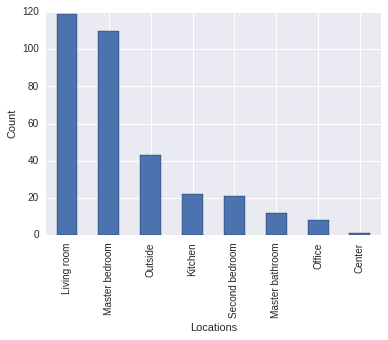

In [1]:
%run LoadAndReduceData.py

dataset.head()

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import clone
from sklearn.datasets import load_iris
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.externals.six.moves import xrange
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split

# Parameters
n_classes = 3
n_estimators = 30
plot_colors = "ryb"
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
iris = load_iris()

plot_idx = 1

models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators),
          ExtraTreesClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                             n_estimators=n_estimators)]

for model in models:
    # We only take the two corresponding features
    X = dataset['sep_hour'].as_matrix()
    y = dataset['location'].as_matrix()
    

    # Shuffle
    idx = np.arange(X.shape[0])
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]

    #Reshape as only single feature
    X = X.reshape(-1,1)
    # Standardize
    #mean = X.mean(axis=0)
    #std = X.std(axis=0)
    #X = (X - mean) / std
    
    #split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.999)
    print(X_train.shape, y_train.shape)

    # Train
    clf = clone(model)
    clf = model.fit(X_train, y_train)

    scores = clf.score(X_test, y_test)
    # Create a title for each column and the console by using str() and
    # slicing away useless parts of the string
    model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")]
    model_details = model_title
    if hasattr(model, "estimators_"):
        model_details += " with {} estimators".format(len(model.estimators_))
    print( model_details + "has a score of", scores )



(161, 1) (161,)
DecisionTreehas a score of 0.583134205153
(161, 1) (161,)
RandomForest with 30 estimatorshas a score of 0.596217702444
(161, 1) (161,)
ExtraTrees with 30 estimatorshas a score of 0.583134205153
(161, 1) (161,)
AdaBoost with 30 estimatorshas a score of 0.583134205153


In [11]:
from bayespy import nodes 
from bayespy.inference import VB 
from scipy.stats import entropy
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import normalize

In [12]:
class DirichletCategoricalModel(object):
    """Bayesian learning for Dirichlet-Categorical Model. 
    
    Attributes:
        
    """
    def __init__(self):
        #Some constants
        self.n_locations = len(location_names.values())
        self.n_timezones = 24 
        
        self.alpha = np.ones(self.n_locations)*0.01
        self.p_theta = nodes.Dirichlet( self.alpha,
                                   plates=(self.n_timezones,),
                                   name='p_theta')
        
    def fit(self, X, y):


        #Taking readings of sep_hour as we know the time in which the reading was taken
        #Reshaing it meet th plates
        recordings_time = X
        self.locations = nodes.Mixture(recordings_time, nodes.Categorical, self.p_theta)
        self.locations.observe(y.reshape(-1,1))
        Q = VB(self.locations, self.p_theta)
        Q.update(repeat=1000)
        self.learned_params = np.array(self.p_theta.get_parameters()).reshape((24,10))
      
    def score(self, X, y):
        df = pd.DataFrame({'sep_hour':X[:,0], 'location':y })
        ct = pd.crosstab( df['location'] , df['sep_hour']).apply(lambda r: r/r.sum(), axis=0)
        self.learned_params = normalize(self.learned_params, axis=1, norm='l1')
        total_prediction = 0
        for tt in np.arange(self.n_timezones):
            #temp = pd.DataFrame(columns=['location','sep_hour'])
            #temp['location'] = random.categorical(learned_params[tt], size= int(dataset.shape[0]/24))
            #temp['location'] = random.categorical(self.learned_params[tt], size= 5000)
            #temp['sep_hour'] = tt
            #print (entropy(self.learned_params[tt],ct[tt]))
            total_prediction += ((1 - np.sum(np.abs (self.learned_params[tt] - ct[tt])))*100)
            
        print(total_prediction/self.n_timezones)
        sns.heatmap(self.learned_params.T, linewidths=.01)
        return(np.argmax(self.learned_params, axis=1))

In [13]:

class HierarchicalAllDirichletCategoricalModel(object):
    """Bayesian learning for Dirichlet-Categorical Model. 
    
    Attributes:
        
    """
    def __init__(self):
        #Some constants
        self.n_locations = len(location_names.values())
        self.n_timezones = 24 
        
        self.p_conc = nodes.DirichletConcentration(10)
        self.p_conc.initialize_from_value(np.ones(self.n_locations)*0.01)
        self.p_theta = nodes.Dirichlet(self.p_conc,
                                  plates=(self.n_timezones,),
                                  name='p_theta')

    def fit(self, X, y):


        #Taking readings of sep_hour as we know the time in which the reading was taken
        #Reshaing it meet th plates
        recordings_time = X
        self.locations = nodes.Mixture(recordings_time, nodes.Categorical, self.p_theta)
        self.locations.observe(y.reshape(-1,1))
        Q = VB(self.locations, self.p_theta, self.p_conc)
        Q.update(repeat=1000)
        self.learned_params = np.array(self.p_theta.get_parameters()).reshape((24,10))
      
    def score(self, X, y):
        df = pd.DataFrame({'sep_hour':X[:,0], 'location':y })
        ct = pd.crosstab( df['location'] , df['sep_hour']).apply(lambda r: r/r.sum(), axis=0)
        self.learned_params = normalize(self.learned_params, axis=1, norm='l1')
        total_prediction = 0
        for tt in np.arange(self.n_timezones):
            #temp = pd.DataFrame(columns=['location','sep_hour'])
            #temp['location'] = random.categorical(learned_params[tt], size= int(dataset.shape[0]/24))
            #temp['location'] = random.categorical(self.learned_params[tt], size= 5000)
            #temp['sep_hour'] = tt
            #print (entropy(self.learned_params[tt],ct[tt]))
            total_prediction += ((1 - np.sum(np.abs (self.learned_params[tt] - ct[tt])))*100)
            
        print(total_prediction/self.n_timezones)
        sns.heatmap(self.learned_params.T, linewidths=.01)
        return(np.argmax(self.learned_params, axis=1))


Iteration 1: loglike=-3.127354e+02 (0.003 seconds)
Iteration 2: loglike=-3.127354e+02 (0.003 seconds)
Converged at iteration 2.
52.60128067916231
[0 0 0 0 0 0 0 0 1 0 9 9 2 9 2 7 2 9 2 2 2 2 2 2]


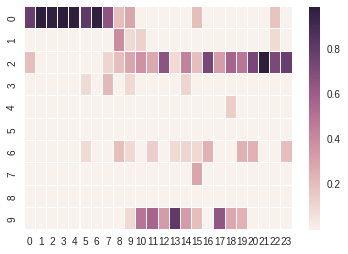

In [14]:
clf = DirichletCategoricalModel()
clf.fit(X_train, y_train)
timezone_max = clf.score(X_test, y_test)
print (timezone_max)

Iteration 1: loglike=-3.383354e+02 (0.011 seconds)
Iteration 2: loglike=-3.135174e+02 (0.012 seconds)
Iteration 3: loglike=-2.960698e+02 (0.013 seconds)
Iteration 4: loglike=-2.835339e+02 (0.013 seconds)
Iteration 5: loglike=-2.742673e+02 (0.012 seconds)
Iteration 6: loglike=-2.674041e+02 (0.013 seconds)
Iteration 7: loglike=-2.623668e+02 (0.013 seconds)
Iteration 8: loglike=-2.586750e+02 (0.012 seconds)
Iteration 9: loglike=-2.559374e+02 (0.012 seconds)
Iteration 10: loglike=-2.538613e+02 (0.012 seconds)
Iteration 11: loglike=-2.522427e+02 (0.012 seconds)
Iteration 12: loglike=-2.509468e+02 (0.012 seconds)
Iteration 13: loglike=-2.498863e+02 (0.012 seconds)
Iteration 14: loglike=-2.490048e+02 (0.012 seconds)
Iteration 15: loglike=-2.482647e+02 (0.012 seconds)
Iteration 16: loglike=-2.476391e+02 (0.009 seconds)
Iteration 17: loglike=-2.471082e+02 (0.007 seconds)
Iteration 18: loglike=-2.466560e+02 (0.007 seconds)
Iteration 19: loglike=-2.462693e+02 (0.010 seconds)
Iteration 20: loglike

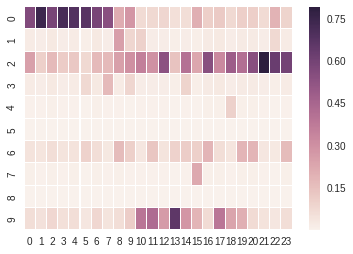

In [15]:

clf = HierarchicalAllDirichletCategoricalModel()
clf.fit(X_train, y_train)
timezone_max = clf.score(X_test, y_test)

In [9]:
print (X_test[:,0])

df = pd.DataFrame({'sep_hour':X_test[:,0],
                   'location':y_test })
ct = pd.crosstab( df['location'] , df['sep_hour']).apply(lambda r: r/r.sum(), axis=0)
print (ct)
print (timezone_max)

total_prediction = 0
for timezone, maxInTime in enumerate(timezone_max):
    print (ct[timezone][maxInTime],
           ct[timezone]['All'], 
           ct[timezone][maxInTime]/ ct[timezone]['All'])
    total_prediction += (ct[timezone][maxInTime]/ ct[timezone]['All'])

print (total_prediction/len(timezone_max))

[ 6 15 12 ..., 14  1  1]
sep_hour        0         1         2         3         4         5   \
location                                                               
0         0.740018  0.917126  0.972727  0.975119  0.972396  0.952516   
1         0.022795  0.003875  0.001341  0.003427  0.007162  0.013588   
2         0.222139  0.067372  0.010730  0.000149  0.000000  0.004480   
3         0.004321  0.000298  0.000149  0.000149  0.000298  0.007317   
4         0.001192  0.000596  0.000000  0.000000  0.000000  0.000000   
5         0.000745  0.001491  0.003279  0.007598  0.007460  0.008511   
6         0.008343  0.009092  0.009687  0.013558  0.012683  0.012991   
7         0.000298  0.000149  0.000149  0.000000  0.000000  0.000000   
8         0.000000  0.000000  0.000000  0.000000  0.000000  0.000597   
9         0.000149  0.000000  0.001937  0.000000  0.000000  0.000000   

sep_hour        6         7         8         9     ...           14  \
location                              

KeyError: 'All'

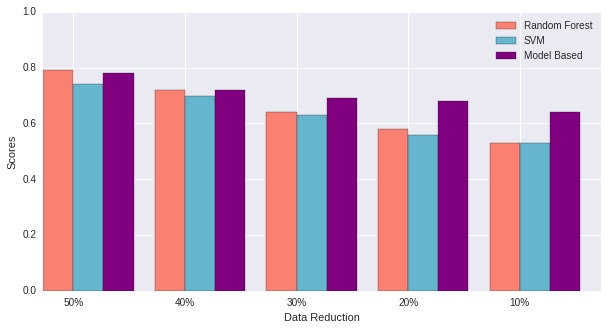

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
sns.set_color_codes()
data_usage = [50, 40, 30, 20, 10]
random_forest = [0.79, 0.72, 0.64, 0.58, 0.53]
svm = [0.74, 0.70, 0.63, 0.56, 0.53]
model_based = [0.78, 0.72, 0.69, 0.68, 0.64]

N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

yvals = [4, 9, 2]
rects1 = ax.bar(ind, random_forest, width, color='salmon')
zvals = [1,2,3]
rects2 = ax.bar(ind+width, svm, width, color='c')
kvals = [11,12,13]
rects3 = ax.bar(ind+width*2, model_based, width, color='purple')

ax.set_ylim([0,1])
ax.set_ylabel('Scores')
ax.set_xlabel('Data Reduction')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('50%', '40%', '30%', '20%', '10%') )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('Random Forest', 'SVM', 'Model Based') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

#autolabel(rects1)
#autolabel(rects2)
#autolabel(rects3)

plt.show()